# 060. Generative Adverserial Networks in PyTorch

- GAN은 훈련하기가 매우 어려울 수 있으며 hyperparameters, activation function 및 regularization 에 매우 민감  

- GAN을 훈련시켜 MNIST 와 비슷한 손으로 쓴 숫자의 이미지를 생성
<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >


- 다음의 순서로 작업

    * MNIST data load 
    * Discriminator network 정의
    * Generator network 정의
    * 손실함수 정의
    * Train the model
    * 중간 출력물 저장
    * model 저장

## Data Loading

- ``torchvision.datasets.MNIST``는 `[0, 1]` 사이로 scaling 되어 있음 

- 픽셀 값을`[0, 1]`범위에서`[-1, 1]`범위로 변환 
$$\frac{x-\mu}{\sigma}$$  
$$\mu : 0.5, \sigma : 0.5$$

- Generator 가 TanH 함수를 activation 으로 이용하여 fake image 를 생성하기 때문에 Generator 의 출력 범위에 맞추어 준다.  

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', train=True, download=True, transform=Compose([
            ToTensor(), 
            Normalize(mean=(0.5,), std=(0.5,))]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
# Device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

- `[-1, 1]`범위로 변환 되었는지 확인

In [3]:
img, label = mnist[0]

print(img[:,10:15,10:15])

torch.min(img), torch.max(img)

tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

- denormalized (0, 1 사이의 원래 값으로 변환) 하는 helper 함수를 정의 

In [4]:
def denorm(x):
    out = x * 0.5 + 0.5
    return out.clamp(0, 1)

In [5]:
denormed = denorm(img[:,10:15,10:15])

print(denormed)

torch.min(denormed), torch.max(denormed)

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


(tensor(0.), tensor(0.9922))

Label: 5


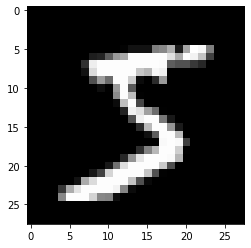

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

### DataLoader 생성

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 100
data_loader = DataLoader(mnist, BATCH_SIZE, shuffle=True)

torch.Size([100, 1, 28, 28])


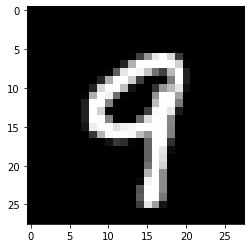

In [8]:
for img, label in data_loader:
    print(img.shape)
    plt.imshow(img[0][0], cmap='gray')
    break;

## Discriminator Network 정의

- 28x28 이미지를 784 크기의 벡터로 취급  
- 3 hidden layer의 간단한 Sequential model 구축  
- 이진분류 모델 - 입력 vector가 real image 입력 이미지가 진짜일 확률 출력  (1-real, 0-fake)
- Leaky ReLU 활성 함수를 사용 (backprop 에서 0 의 기울기(경사)를 전달하는 대신 작은 음의 기울기를 전달)  

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="360">

In [9]:
image_size = 784
hidden_unit = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_unit),
    nn.LeakyReLU(0.2),      # x < 0 이면 y=0.2x
    nn.Linear(hidden_unit, hidden_unit),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_unit, 1),
    nn.Sigmoid())

In [11]:
D.to(device);
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator Network 정의

- Generator 에 대한 입력은 이미지를 생성하기 위한 시드(seed)로 사용되는 latent vector  
- 3 개의 레이어로 구성된 신경망  
- 출력은 28x28 pixel 이미지로 변환될 수 있는 784 크기의 벡터  
- Generator 의 출력 레이어에 TanH 활성화 함수를 사용 (input image를 [-1, 1] 로 전처리 했으므로)

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="240" >

In [18]:
latent_size = 64 

In [19]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_unit),
    nn.ReLU(),
    nn.Linear(hidden_unit, hidden_unit),
    nn.ReLU(),
    nn.Linear(hidden_unit, image_size),
    nn.Tanh())
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [20]:
y = G(torch.randn(latent_size))  # 랜덤 노이즈를 G에 입력
y.shape

torch.Size([784])

In [21]:
gen_img = denorm(y.reshape((28, 28))).detach().numpy()
gen_img.shape

(28, 28)

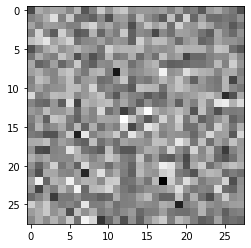

In [22]:
plt.imshow(gen_img, cmap='gray');

In [23]:
G.to(device);

## Discriminator(감별자) Training

- 감별자는 이진 분류 모델이므로 binary cross entropy 손실 함수를 사용  

### 감별자 훈련 단계

- image가 실제의 MNIST에서 제공되면 감별자는 1을 출력해야 한다.
- 생성자(Generator)가 생성한 image인 경우 0을 출력해야 한다.    

- 먼저 실제 이미지 배치를 전달하고 대상 레이블을 1로 설정하여 손실을 계산
- 그런 다음 generator 를 사용하여 가짜 이미지 배치를 생성하고 대상 레이블을 0으로 설정하여 descriminator 에 전달한 다음 손실을 계산  

- 두 손실을 더하고 전체 손실을 사용하여 Gradient Descent를 수행하여 Discriminator의 weight를 조정  

- 감별자를 훈련시키는 동안 생성자 모델의 가중치를 변경하지 않는다는 점에 유의 (`d_optimizer`는`D.parameters ()`에만 영향을 미침).

In [24]:
criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

- gradient reset 및 discriminator train helper 함수 정의

In [25]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
def train_discriminator(real_images):
    # BCE loss 계산에 사용할 label 생성
    real_labels = torch.ones(BATCH_SIZE, 1).to(device)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
    
    # real image를 D가 얼마나 잘 감별했는지 loss 계산
    yhats = D(real_images)    # 잘 감별했으면 모두 1
    d_loss_real = criterion(yhats, real_labels)
    real_score = yhats
    
    # fake image를 D가 얼마나 잘 감별했는지 loss 계산
    # fake image 생성
    z = torch.randn(BATCH_SIZE, latent_size).to(device)
    fake_images = G(z)
    
    yhats = D(fake_images)  # 잘 감별했으면 모두 0
    d_loss_fake = criterion(yhats, fake_labels)
    fake_score = yhats
    
    # 두 loss를 combine
    d_loss = d_loss_real + d_loss_fake
    
    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

## Generator Training

- 생성자의 출력은 이미지이므로 **손실 함수의 일부로 감별자를 사용**하는 트릭을 사용  

- 작동 방식은 다음과 같다.

    - 생성자를 사용하여 이미지 배치를 생성하고 감별자에 전달.

    - target 레이블을 1, 즉 real 로 설정하여 손실을 계산. (생성자의 목표는 감별자를 속이는 것이기 때문)

    - 손실을 사용하여 경사 하강을 수행. 즉, 생성자의 weight 를 변경하므로 점점 더 실제 같은 이미지를 생성하게 된다.

In [26]:
def train_generator():
    # 가짜 image 생성 및 loss 계산
    z = torch.randn(BATCH_SIZE, latent_size).to(device)
    fake_images = G(z)
    
    labels = torch.ones(BATCH_SIZE, 1).to(device)
    g_loss = criterion(D(fake_images), labels)  # D가 속으면 모두 1 return
    
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model

- 모델의 진행 상황을 육안으로 검사하기 위해 생성기의 중간 출력을 저장할 수있는 디렉토리를 생성

In [27]:
import os

sample_dir = "gan_samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

- 생성 된 이미지를 보면서 시각적 비교에 사용할 수있는 실제 이미지 배치를 저장

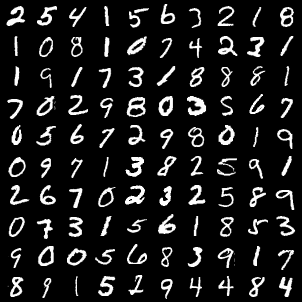

In [28]:
from IPython.display import Image
from torchvision.utils import save_image

# real image 일부 저장
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
    
Image(os.path.join(os.path.abspath(sample_dir), 'real_images.png'))

- 각 epoch 이 끝날 때 마다 생성된 이미지를 디스크에 저장하는 helper function 을 정의  

- 모델을 학습함에 따라 생성된 개별 이미지가 시간이 지남에 따라 어떻게 진화하는지 확인하기 위해 고정된 입력 벡터 세트를 generator 에 입력으로 제공

In [29]:
sample_vectors = torch.randn(BATCH_SIZE, latent_size).to(device)
sample_vectors.shape

torch.Size([100, 64])

Saved.. fake_images-0000.png


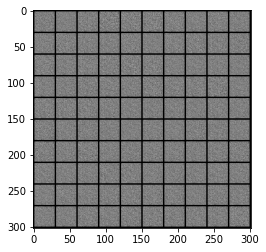

In [30]:
def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = f'fake_images-{index:0=4d}.png'
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    print("Saved..", fake_fname)
    img = plt.imread((os.path.join(os.path.abspath(sample_dir), fake_fname)))
    plt.imshow(img)
    plt.show()
    
# Before training
save_fake_images(0)

## Train 

- 각 epoch 마다 먼저 Discriminator 를 훈련시킨 다음 Generator 를 훈련시킨다.
- GPU 필요

Epoch [0/300], Step [200/600], d_loss: 0.0323, g_loss: 4.3698, D(x): 0.99, G(x):0.02
Epoch [0/300], Step [400/600], d_loss: 0.3585, g_loss: 3.9860, D(x): 0.89, G(x):0.18
Epoch [0/300], Step [600/600], d_loss: 0.0410, g_loss: 4.6958, D(x): 0.98, G(x):0.02
Saved.. fake_images-0001.png


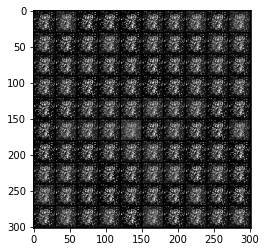

Epoch [1/300], Step [200/600], d_loss: 0.1594, g_loss: 5.0137, D(x): 0.91, G(x):0.03
Epoch [1/300], Step [400/600], d_loss: 0.0453, g_loss: 5.1165, D(x): 0.97, G(x):0.01
Epoch [1/300], Step [600/600], d_loss: 0.1448, g_loss: 5.3058, D(x): 0.94, G(x):0.04
Saved.. fake_images-0002.png


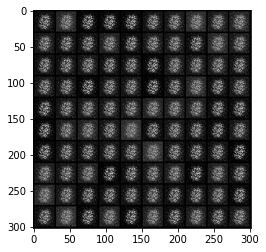

Epoch [2/300], Step [200/600], d_loss: 0.3952, g_loss: 3.4459, D(x): 0.85, G(x):0.12
Epoch [2/300], Step [400/600], d_loss: 0.2057, g_loss: 4.0075, D(x): 0.93, G(x):0.06
Epoch [2/300], Step [600/600], d_loss: 0.2505, g_loss: 3.0637, D(x): 0.95, G(x):0.16
Saved.. fake_images-0003.png


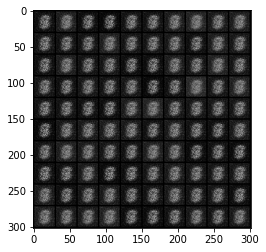

Epoch [3/300], Step [200/600], d_loss: 0.5510, g_loss: 3.0625, D(x): 0.78, G(x):0.12
Epoch [3/300], Step [400/600], d_loss: 1.3178, g_loss: 2.5596, D(x): 0.63, G(x):0.27
Epoch [3/300], Step [600/600], d_loss: 0.7733, g_loss: 1.9718, D(x): 0.83, G(x):0.31
Saved.. fake_images-0004.png


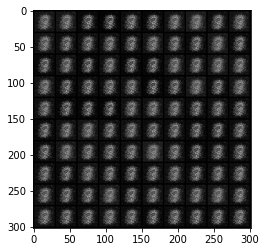

Epoch [4/300], Step [200/600], d_loss: 2.0807, g_loss: 1.8503, D(x): 0.67, G(x):0.60
Epoch [4/300], Step [400/600], d_loss: 0.1992, g_loss: 3.6596, D(x): 0.90, G(x):0.06
Epoch [4/300], Step [600/600], d_loss: 0.3492, g_loss: 3.0928, D(x): 0.86, G(x):0.11
Saved.. fake_images-0005.png


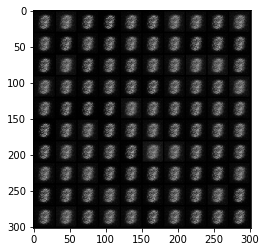

Epoch [5/300], Step [200/600], d_loss: 0.2059, g_loss: 3.2623, D(x): 0.92, G(x):0.09
Epoch [5/300], Step [400/600], d_loss: 0.5399, g_loss: 2.9451, D(x): 0.84, G(x):0.21
Epoch [5/300], Step [600/600], d_loss: 1.0242, g_loss: 2.5689, D(x): 0.65, G(x):0.22
Saved.. fake_images-0006.png


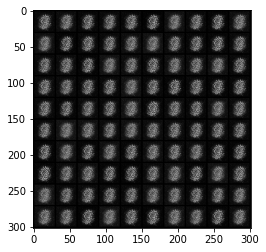

Epoch [6/300], Step [200/600], d_loss: 1.0686, g_loss: 2.2017, D(x): 0.63, G(x):0.19
Epoch [6/300], Step [400/600], d_loss: 0.5915, g_loss: 2.5689, D(x): 0.78, G(x):0.15
Epoch [6/300], Step [600/600], d_loss: 0.6314, g_loss: 3.5038, D(x): 0.77, G(x):0.16
Saved.. fake_images-0007.png


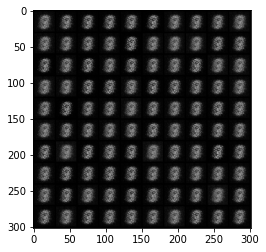

Epoch [7/300], Step [200/600], d_loss: 0.3016, g_loss: 2.9318, D(x): 0.88, G(x):0.12
Epoch [7/300], Step [400/600], d_loss: 0.3898, g_loss: 2.7080, D(x): 0.81, G(x):0.06
Epoch [7/300], Step [600/600], d_loss: 0.1670, g_loss: 3.4072, D(x): 0.93, G(x):0.05
Saved.. fake_images-0008.png


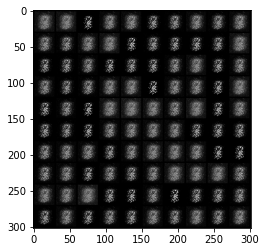

Epoch [8/300], Step [200/600], d_loss: 0.1243, g_loss: 4.5363, D(x): 0.96, G(x):0.02
Epoch [8/300], Step [400/600], d_loss: 0.1520, g_loss: 5.1837, D(x): 0.96, G(x):0.05
Epoch [8/300], Step [600/600], d_loss: 0.2808, g_loss: 5.8311, D(x): 0.95, G(x):0.14
Saved.. fake_images-0009.png


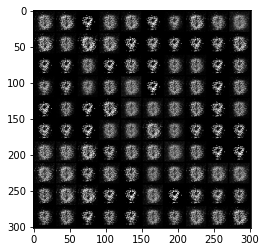

Epoch [9/300], Step [200/600], d_loss: 0.0434, g_loss: 5.2120, D(x): 0.98, G(x):0.01
Epoch [9/300], Step [400/600], d_loss: 0.3478, g_loss: 3.5578, D(x): 0.94, G(x):0.16


KeyboardInterrupt: ignored

In [31]:
import time
st = time.time()

num_epochs = 300
total_steps = len(data_loader)

d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(BATCH_SIZE, -1).to(device) # 28*28 -> 724
        
        # 감별자 훈련 후 생성자 훈련
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_steps}], ' + 
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, ' +
                  f'D(x): {real_score.mean():.2f}, G(x):{fake_score.mean():.2f}')
            
    save_fake_images(epoch+1)

print("Total time elapsed :", time.time() - st)

모델을 학습 했으므로 checkpoint 를 저장할 수 있습니다.

In [ ]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'D.ckpt')
torch.save(D.state_dict(), 'G.ckpt')

10, 50, 100, 300 epoch 훈련 후 생성된 이미지가 어떻게 보이는지 보여줍니다.

In [ ]:
Image('./gan_samples/fake_images-0010.png')

In [ ]:
Image('./gan_samples/fake_images-0030.png')

In [ ]:
Image('./gan_samples/fake_images-0050.png')

In [ ]:
Image('./gan_samples/fake_images-0100.png')

- 처음에는 Discriminator 가 잘 구별 하므로 D 의 손실이 낮고 G 의 손실이 높지만 시간이 갈 수록 둘이 수렴하는 모습을 보여야 한다.

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

- D 가 초기에는 Real 과 Fake 를 잘 감별하므로 real_score 는 1 에 fake_score 는 0 에 가깝게 시작하지만 시간이 흐를 수록 real_score 가 떨어지고 fake_score 가 올라가서 수렴하는 모양이 되어야 한다.

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');